In [1]:
import numpy as np
from pprint import pprint

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, cross_validate
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
from scipy.stats import loguniform

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('figure', figsize=(8, 6))

In [5]:
import ssl
import urllib.request

ssl._create_default_https_context = ssl._create_unverified_context

urllib.request.install_opener(
    urllib.request.build_opener(
        urllib.request.HTTPSHandler(context=ssl._create_default_https_context())
    )
)

X, y = fetch_openml('mnist_784', version=1, as_frame=True, return_X_y=True)

print(X.shape, y.shape)

(70000, 784) (70000,)


In [6]:
X = X.to_numpy()
y = y.to_numpy()

In [7]:
scaler = MinMaxScaler()
x  = scaler.fit_transform(X)

In [8]:
print('Mean: ', np.mean(x))
print('Standard Deviation: ', np.std(x))
print('Minimum Value: ', np.min(x))
print('Maximum Value: ', np.max(x))

Mean:  0.13092720382627604
Standard Deviation:  0.3084510570135976
Minimum Value:  0.0
Maximum Value:  1.0


In [9]:
target_names = np.unique(y)
print("Number of samples: {0}, type: {1}".format(X.shape[0], x.dtype))
print('Number of features: {0}'.format(x.shape[1]))
print("Number of classes: {0}, type: {1}".format(len(target_names), y.dtype))
print("Labels: ",target_names)

Number of samples: 70000, type: float64
Number of features: 784
Number of classes: 10, type: object
Labels:  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


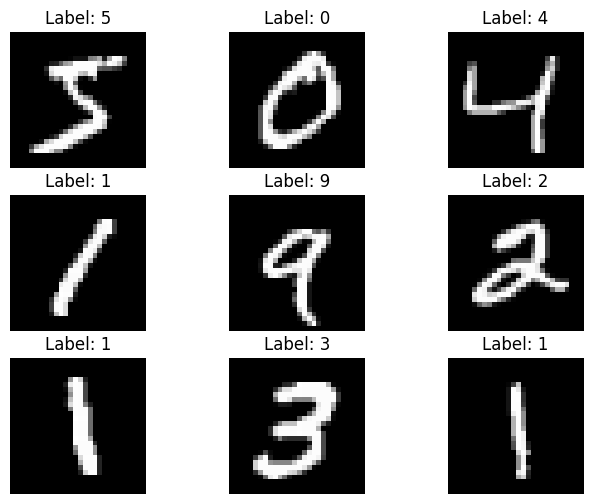

In [10]:
num_images = 9
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8, 6))
idx_offset = 0
for i in range(factor):
    index = idx_offset + i * factor
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap='gray')
        ax[i, j].set_title('Label: {0}'.format(str(y[index + j])))
        ax[i, j].set_axis_off()

In [11]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [12]:
y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1

indx_0 = np.where(y_test == '0')
y_test[indx_0] = 1

In [13]:
print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[0. 1. 0. ... 0. 0. 0.]


In [14]:
print(np.where(y_train=='0'))
print(np.where(y_train_0==1))

(array([    1,    21,    34, ..., 59952, 59972, 59987]),)
(array([    1,    21,    34, ..., 59952, 59972, 59987]),)


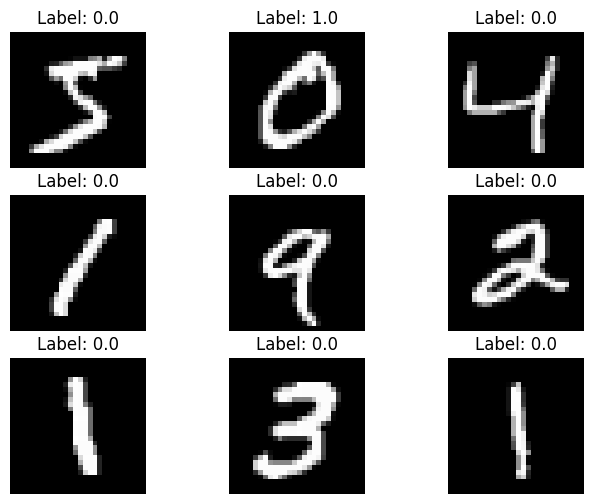

In [15]:
num_images = 9
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8, 6))
idx_offset = 0
for i in range(factor):
    index = idx_offset + i * factor
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap='gray')
        ax[i, j].set_title('Label: {0}'.format(str(y_train_0[index + j])))
        ax[i, j].set_axis_off()

In [17]:
pipe_logit = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729, solver='lbfgs', C=np.inf))
pipe_logit.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

grid_Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

scaler = MinMaxScaler()
logreg = LogisticRegression(C=1.0, random_state=1729)

pipe = Pipeline(steps=[("scaler", scaler),
                       ("logistic", logreg)])

pipe_logit_cv = GridSearchCV(
    pipe, 
    param_grid={"logistic__C":grid_Cs},
    scoring='f1'
)

pipe_logit_cv.fit(x_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

In [23]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

In [24]:
pipe_logit_cv.best_score_

np.float64(0.9582781080330685)

In [25]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

In [26]:
from sklearn.linear_model import LogisticRegressionCV


estimator = LogisticRegressionCV(cv=5, scoring='f1', random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(), estimator)
logit_cv.fit(x_train, y_train_0)